<font size = 10> **Creating a mask for MEASO regions** </font>

Our analysis uses the [Marine Ecosystem Assessment for the Southern Ocean (MEASO) regions](https://sokiaq.atlassian.net/wiki/spaces/MEASO/pages/4348444548/MEASO+Approach+Structure+Format) to evaluate and quantify the rate of change in the physical environment of the Southern Ocean. These regions were designed to establish a standard spatial scale for reporting and assessing environmental and ecosystem change in the SO, and to facilitate comparisons across studies and throughout time. The MEASO regions boundaries were obtained from the [`measoshape`](https://australianantarcticdivision.github.io/measoshapes/) package for `R`.  We used this shapefile (i.e., polygon) to create a 3D mask that we will use for all the analyses at a sector level that are described in this series of notebooks.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [15]:
import os
#Ensure you update this filepath if you have saved these notebooks elsewhere in your machine
os.chdir(os.path.expanduser('~/ACCESS-OM2-01_EcologicallyRelevantVariables/Scripts'))

#Checking current working directory - This should match the location of the scripts in your machine
!pwd

# Loading relevant libraries
Note that the `ZonalStatsFuncions` refers to a `Python` script that contains functions that were commonly used throughout this work.

In [16]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import geopandas
import regionmask
import numpy as np
import ZonalStatsFunctions as zsf

# Loading shapefile with MEASO regions
As noted in the introduction, the shapefile with the MEASO regions boundaries comes from the `measoshapes` package for `R`. Note that MEASO includes three latitudinal zones: Antarctic, Subantarctic and Northern, but the original shapefile includes a fourth *Temperate* zone. We will remove the *Temperate* zone because it is not relevant to our work.

<AxesSubplot:>

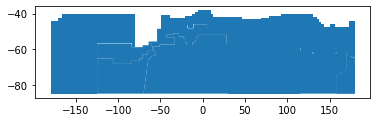

In [20]:
#Loading the MEASO shapefile
regions = geopandas.read_file(r'../Shapefiles/MEASO/measo_wgs84.shp')
#Removing the temperate zone
regions = regions.query('zone != "Temperate"')
       
#Plotting shapefile
regions.plot()

# Loading ACCESS-OM2 data sample for the Southern Ocean 

In [3]:
#Accessing COSIMA cookbook
import cosima_cookbook as cc
session = cc.database.create_session()

#Loading data
data =  cc.querying.getvar('01deg_jra55v140_iaf_cycle2', 'area_t', 
                           session, frequency = 'static', n = -1)
data = data.sel(yt_ocean = slice(-80, -35))
data = zsf.corrlong(data)
data

<xarray.DataArray 'area_t' (yt_ocean: 844, xt_ocean: 3600)>
dask.array<getitem, shape=(844, 3600), dtype=float32, chunksize=(513, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -35.2 -35.12 -35.04
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t

## Regridded data

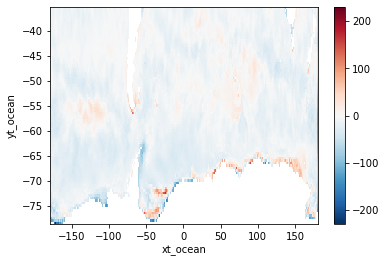

In [4]:
import copy
#Load data 
data = xr.open_dataarray('/g/data/v45/la6889/Calculations/MLD/Climatologies/Diff_Mod_Obs/Diff_Mod-Obs_Clim_Autumn_1970-2018.nc')

#Correct longitude values so they go from -180 to +180
corr_lon = copy.deepcopy(data.lon.values)
corr_lon[np.where(corr_lon > 180)] = sorted(corr_lon[np.where(corr_lon > 180)]-360)
data.coords['lon'] = corr_lon
#Sort data by longitude
data = data.sortby(data.lon)
#Rename coordinate data
data = data.rename({'lon':'xt_ocean', 'lat': 'yt_ocean'})

#Plot results
data.plot()

# Checking MEASO regions and ACCESS-OM2 data are correctly aligned

<AxesSubplot:xlabel='xt_ocean', ylabel='yt_ocean'>

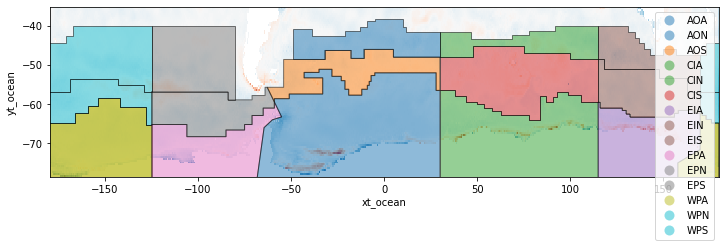

In [5]:
# Plot shapefile over the raster to ensure they both have the same CRS and cover the same area
#Initialise figure
fig, ax = plt.subplots(figsize = (12, 15))

#Plot just one timestep of the data array
data.plot(ax = ax, add_colorbar = False)

#Plot shapefile over the top and show each sector in different colour
regions.plot(ax = ax, column = 'name', legend = True, alpha = 0.5, edgecolor = 'black')

# Creating an xarray mask of the MEASO regions

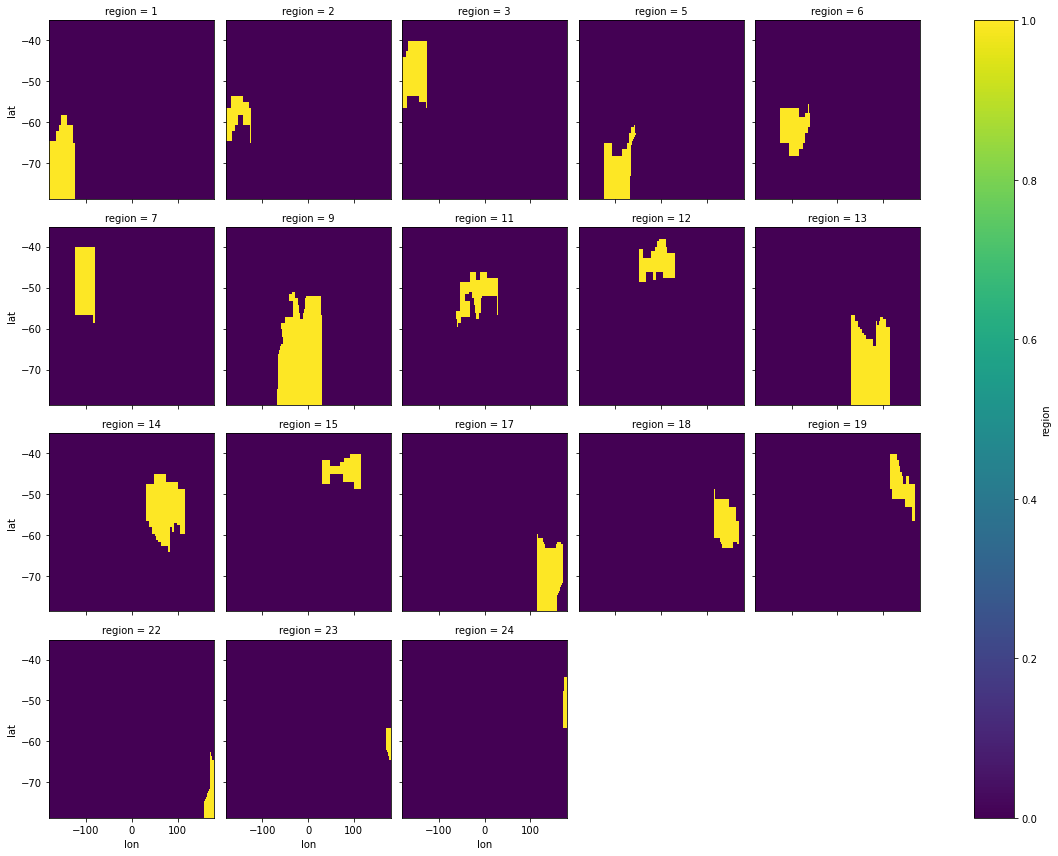

In [18]:
# Extracting latitude and longitude values from SO data array
xt_ocean = data['xt_ocean'].values
yt_ocean = data['yt_ocean'].values

#Creating a 3D mask, which includes regions as a dimension
mask3D = regionmask.mask_3D_geopandas(regions, xt_ocean, yt_ocean)
#Plotting all regions within mask to check they are correct
mask3D.plot(col = 'region', col_wrap = 5)

## Renaming regions
When the mask was created, numeric values were assigned to the `region` dimension which correspond to their index in the shapefile used to create the mask. In this step, regions will be renamed so the shorten version of its name (column `name` in the shapefile) will appear as the value in the `region` dimension of the mask.

In [20]:
#Getting names of regions from the shapefile to include them in mask (keep the same order as they appear)
reg_names = regions.LongName.values.tolist()

#Remove the first and 12th item in the list as it is not included in the mask (see figure above) 
del reg_names[0]
del reg_names[-4]
reg_names

#Replacing numbered regions for names in the mask
mask3D['region'] = reg_names

#Checking results
mask3D.region

<xarray.DataArray 'region' (region: 18)>
array(['West Pacific Antarctic', 'West Pacific Subantarctic',
       'West Pacific Northern', 'East Pacific Antarctic',
       'East Pacific Subantarctic', 'East Pacific Northern',
       'Atlantic Antarctic', 'Atlantic Subantarctic', 'Atlantic Northern',
       'Central Indian Antarctic', 'Central Indian Subantarctic',
       'Central Indian Northern', 'East Indian Antarctic',
       'East Indian Subantarctic', 'East Indian Northern',
       'West Pacific Antarctic', 'West Pacific Subantarctic',
       'West Pacific Northern'], dtype='<U27')
Coordinates:
  * region   (region) <U27 'West Pacific Antarctic' ... 'West Pacific Northern'

## Merging duplicate West Pacific areas
Areas within the West Pacific sector appear twice in the mask. This is because these areas are split in two along the -180/+180 longitude boundary.  
Areas with the same name will be summed together. Since each area is a boolean, the resulting data array will include `True` only for pixels within the boundaries of each area.  
*Remember boolean data represent `True` as `1` and `False` as `0`.*

In [21]:
#Creating a list of repeated sectors
import collections
repeated = [i for i, count in collections.Counter(mask3D.region.values).items() if count > 1]

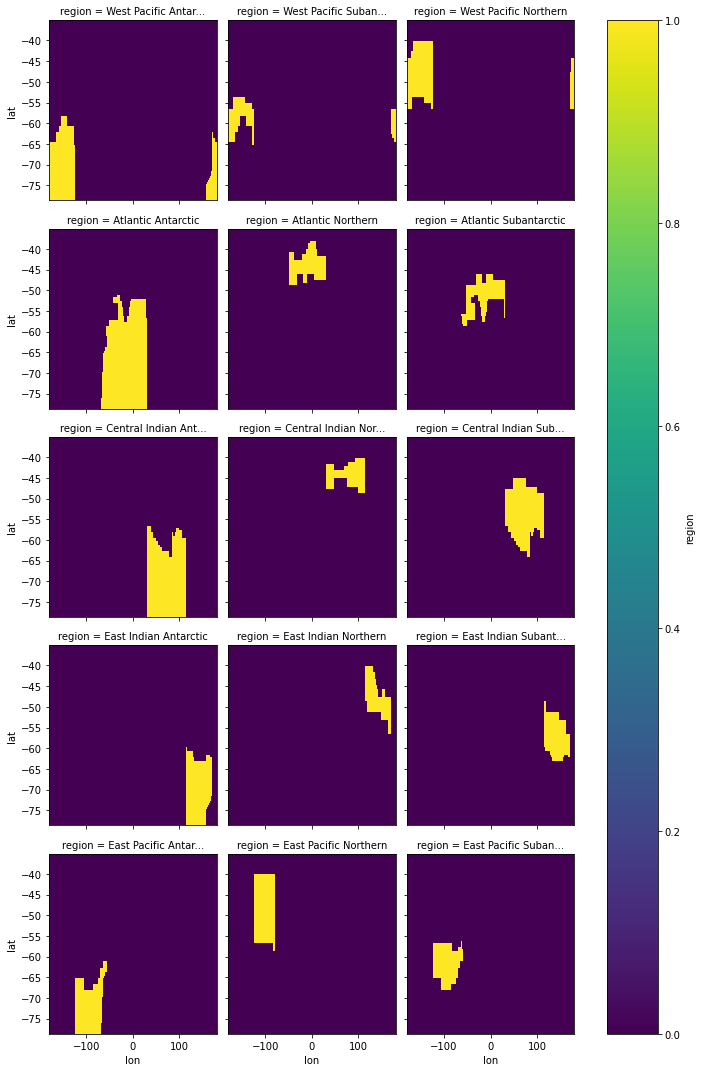

In [22]:
#Creating an empty variable to store the corrected areas
corr_reg = []

#We will loop through each repeated area
for i in repeated:
    reg = [i]
    #Sum together areas with the same value under region
    x = mask3D.sel(region = i).sum('region')
    #Include the region dimension again as this will be automatically dropped after summing
    x = x.expand_dims({'region': reg})
    #Include resulting data arrays in the empty variable created at the beginning of this section
    corr_reg.append(x)

#Appending all other regions
non_rep = sorted([sec for sec in set(mask3D.region.values) if sec not in repeated])
for i in non_rep:
    reg = [i]
    #Sum together areas with the same value under region
    x = mask3D.sel(region = i)
    #Include the region dimension again as this will be automatically dropped after summing
    x = x.expand_dims({'region': reg})
    #Include resulting data arrays in the empty variable created at the beginning of this section
    corr_reg.append(x)
        
#Concatenate all information into one new data array
corrected_mask = xr.concat(corr_reg, 'region')

#Checking the final result, which should include 25 areas in total
corrected_mask.plot(col = 'region', col_wrap = 3)

### Additional steps if longitude needs to be between 0-360 degrees

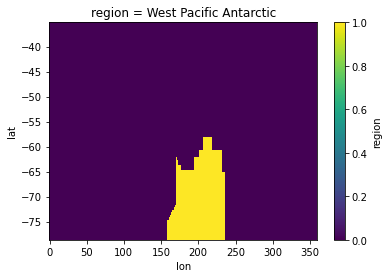

In [23]:
corr_lon = copy.deepcopy(corrected_mask.lon.values)
corr_lon[np.where(corr_lon < 0)] = sorted(corr_lon[np.where(corr_lon < 0)]+360)
corrected_mask.coords['lon'] = corr_lon
corrected_mask = corrected_mask.sortby(corrected_mask.lon)
corrected_mask[0].plot()

## Replacing zero values with NaN

In [24]:
corrected_mask = corrected_mask.where(corrected_mask != 0)

## Renaming coordinate dimensions
Coordinate dimensions are renamed so they match the names in ACCESS-ESM1.5.

In [17]:
corrected_mask = corrected_mask.rename({'lon': 'xt_ocean','lat': 'yt_ocean'})

## Checking mask has been correctly calculated

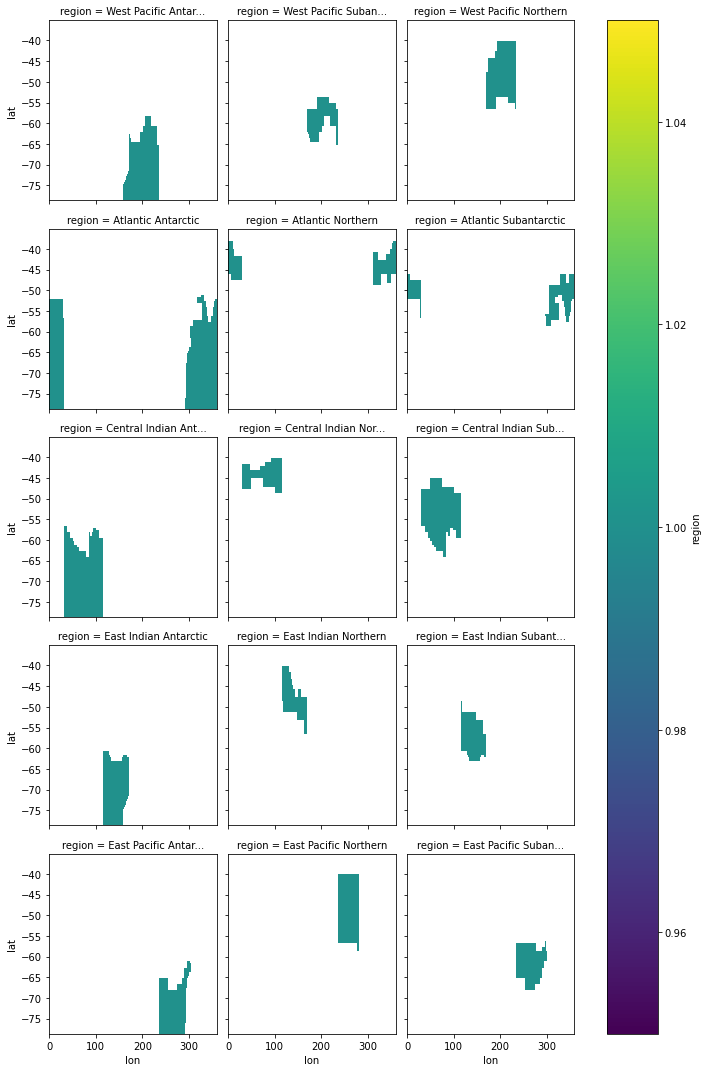

In [25]:
corrected_mask.plot(col = 'region', col_wrap = 3)

## Saving the resulting mask

In [107]:
corrected_mask.to_netcdf('MEASO_3Dmask.nc')
# corrected_mask.to_netcdf('MEASO_3Dmask_regridded.nc')